## Load Import packages

In [ ]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 3.0 MB 33.9 MB/s 
     |████████████████████████████████| 895 kB 27.5 MB/s 


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.5 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=9c104000fe0b012f196901ef4d6f59f55ebbe8a4a9ce5f54e0dcac63617d6805
  Stored in directory: /tmp/pip-ephem-wheel-cache-flp240pi/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import sys, os

from transformers import AutoTokenizer, BertModel, GPT2Model
import argparse
import en_core_web_md
from tqdm import tqdm
import json
import spacy
import numpy as np
import torch
import re

In [ ]:
#Remember to restart if 'en_core_web_md' is not loading -> Runtime/Restart runtime

nlp = spacy.load('en_core_web_md')
nlp

In [ ]:
def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [ ]:
use_cuda = True
language_model = "bert-large-cased"
tokenizer = AutoTokenizer.from_pretrained(language_model)
encoder = BertModel.from_pretrained(language_model)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
#This model(bert-large-cased) has the following configuration:

#24-layer
#1024 hidden dimension
#16 attention heads
#336M parameters.

#Datasets used to train bert-large-cased
#wikipedia
#bookcorpus

encoder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
if use_cuda:
        encoder = encoder.cuda()

In [ ]:
include_sentence = False

In [ ]:
subtoken_ids = tokenizer(str('Prince'), add_special_tokens=False) #['input_ids']
subtoken_ids

{'input_ids': [2558], 'token_type_ids': [0], 'attention_mask': [1]}

In [ ]:
sentence

'Prince Andrew took out a £1.5m personal loan that was subsequently paid off by companies connected to David Rowland, a multimillionaire Conservative donor and financier, it has been claimed'

In [ ]:
token2id

{',': 18,
 'David Rowland': 13,
 'Prince Andrew': 0,
 'a multimillionaire Conservative donor': 15,
 'a £1.5m personal loan': 3,
 'and': 16,
 'been': 20,
 'by': 9,
 'claimed': 21,
 'companies': 10,
 'connected': 11,
 'financier': 17,
 'has': 19,
 'it': 18,
 'off': 8,
 'out': 2,
 'paid': 7,
 'subsequently': 6,
 'that': 4,
 'to': 12,
 'took': 1,
 'was': 5}

In [ ]:
def create_mapping(sentence, return_pt=False, nlp = None, tokenizer=None):
    '''Create a mapping
        nlp: spacy model
        tokenizer: huggingface tokenizer
    '''
    doc = nlp(sentence)

    tokens = list(doc)

    chunk2id = {}

    start_chunk = []
    end_chunk = []
    noun_chunks = []
    for chunk in doc.noun_chunks:
        noun_chunks.append(chunk.text)
        start_chunk.append(chunk.start)
        end_chunk.append(chunk.end)

    sentence_mapping = []
    token2id = {}
    mode = 0 # 1 in chunk, 0 not in chunk
    chunk_id = 0
    for idx, token in enumerate(doc):
        if idx in start_chunk:
            mode = 1
            sentence_mapping.append(noun_chunks[chunk_id])
            token2id[sentence_mapping[-1]] = len(token2id)
            chunk_id += 1
        elif idx in end_chunk:
            mode = 0

        if mode == 0:
            sentence_mapping.append(token.text)
            token2id[sentence_mapping[-1]] = len(token2id)


    token_ids = []
    tokenid2word_mapping = []

    for token in sentence_mapping:
        subtoken_ids = tokenizer(str(token), add_special_tokens=False)['input_ids']
        tokenid2word_mapping += [ token2id[token] ]*len(subtoken_ids)
        token_ids += subtoken_ids

    tokenizer_name = str(tokenizer.__str__)
    outputs = {
            'input_ids': [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id],
            'attention_mask': [1]*(len(token_ids)+2),
            'token_type_ids': [0]*(len(token_ids)+2)
        }

    if return_pt:
        for key, value in outputs.items():
            outputs[key] = torch.from_numpy(np.array(value)).long().unsqueeze(0)
    
    return outputs, tokenid2word_mapping, token2id, noun_chunks

### Solution Architecture

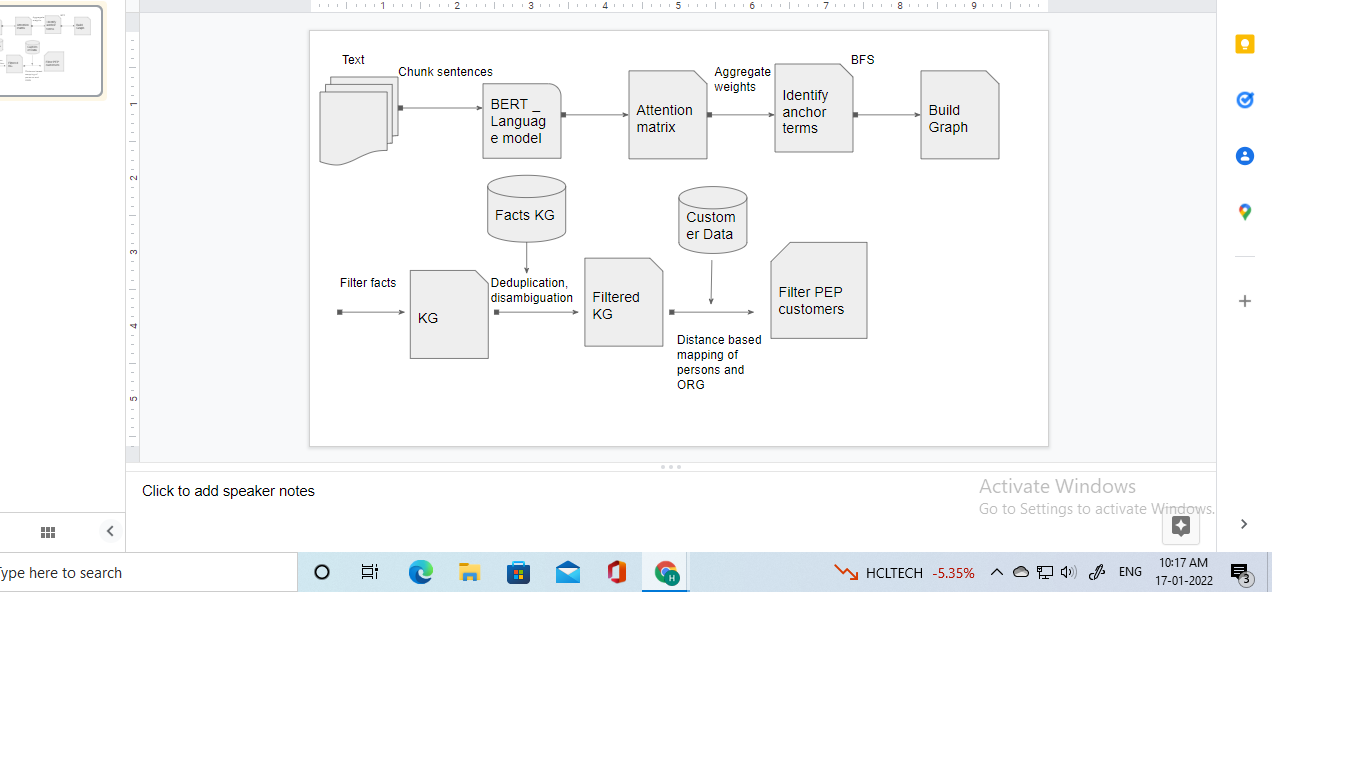

In [ ]:
sentence = 'Prince Andrew took out a £1.5m personal loan that was subsequently paid off by companies connected to David Rowland, a multimillionaire Conservative donor and financier, it has been claimed'


In [ ]:
sentence

'Prince Andrew took out a £1.5m personal loan that was subsequently paid off by companies connected to David Rowland, a multimillionaire Conservative donor and financier, it has been claimed'

In [ ]:
tokenizer_name = str(tokenizer.__str__)


In [ ]:
inputs, tokenid2word_mapping, token2id, noun_chunks  = create_mapping(sentence, return_pt=True, nlp=nlp, tokenizer=tokenizer)

In [ ]:
#attention_mask -> 1 attention on a token , 0 padded token
#token_type_ids -> sentence 0 , sentence 1 etc
inputs

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  2558,  3217,  1261,  1149,   170, 15142,   119,   126,  1306,
           2357,  4891,  1115,  1108,  2886,  3004,  1228,  1118,  2557,  3387,
           1106,  1681, 22473,   117,   170,  4321, 11734,  1988,  9674,  5739,
          16667,  1105, 15301,  1389, 26656,   117,  1122,  1144,  1151,  2694,
            102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
token2id

{',': 18,
 'David Rowland': 13,
 'Prince Andrew': 0,
 'a multimillionaire Conservative donor': 15,
 'a £1.5m personal loan': 3,
 'and': 16,
 'been': 20,
 'by': 9,
 'claimed': 21,
 'companies': 10,
 'connected': 11,
 'financier': 17,
 'has': 19,
 'it': 18,
 'off': 8,
 'out': 2,
 'paid': 7,
 'subsequently': 6,
 'that': 4,
 'to': 12,
 'took': 1,
 'was': 5}

In [ ]:
noun_chunks

['Prince Andrew',
 'a £1.5m personal loan',
 'companies',
 'David Rowland',
 'a multimillionaire Conservative donor',
 'financier',
 'it']

In [ ]:
def process_matrix(attentions, layer_idx = -1, head_num = 0, avg_head=False, trim=True, use_cuda=True):
    if avg_head:
        if use_cuda:
            attn =  torch.mean(attentions[0][layer_idx], 0).cpu()
        else:
            attn = torch.mean(attentions[0][layer_idx], 0)
        attention_matrix = attn.detach().numpy()
    else:
        attn = attentions[0][layer_idx][head_num]
        if use_cuda:
            attn = attn.cpu()
        attention_matrix = attn.detach().numpy()

    attention_matrix = attention_matrix[1:-1, 1:-1]

    return attention_matrix    

In [ ]:

torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
torch.cuda.device_count()

1

In [ ]:
use_cuda = True
with torch.no_grad():
        if use_cuda:
            for key in inputs.keys():
                inputs[key] = inputs[key].cuda()
        outputs = encoder(**inputs, output_attentions=True)
trim = True

#Use average of last layer attention 

attention = process_matrix(outputs[2], avg_head=True, trim=trim, use_cuda=use_cuda)
attention[:1]

array([[0.0295173 , 0.10170265, 0.026673  , 0.02275837, 0.0114554 ,
        0.03647727, 0.01236529, 0.01359847, 0.01704007, 0.02393565,
        0.03013557, 0.00910466, 0.01233257, 0.0152789 , 0.02290349,
        0.01079827, 0.01046885, 0.01893551, 0.01091521, 0.00653262,
        0.04111445, 0.04843356, 0.00946991, 0.00702427, 0.01563373,
        0.0180072 , 0.0138209 , 0.02922081, 0.04308105, 0.0256399 ,
        0.01032436, 0.01529818, 0.01619486, 0.03395575, 0.00851127,
        0.00700823, 0.01120332, 0.00871392, 0.022394  ]], dtype=float32)

In [ ]:
def compress_attention(attention, tokenid2word_mapping, operator=np.mean):

    new_index = []
    
    prev = -1
    for idx, row in enumerate(attention):
        token_id = tokenid2word_mapping[idx]
        if token_id != prev:
            new_index.append( [row])
            prev = token_id
        else:
            new_index[-1].append(row)

    new_matrix = []
    for row in new_index:
        new_matrix.append(operator(np.array(row), 0))

    new_matrix = np.array(new_matrix)

    attention = np.array(new_matrix).T

    prev = -1
    new_index=  []
    for idx, row in enumerate(attention):
        token_id = tokenid2word_mapping[idx]
        if token_id != prev:
            new_index.append( [row])
            prev = token_id
        else:
            new_index[-1].append(row)

    
    new_matrix = []
    for row in new_index:
        new_matrix.append(operator(np.array(row), 0))
    
    new_matrix = np.array(new_matrix)

    return new_matrix.T

In [ ]:
def build_graph(matrix):
    graph = defaultdict(list) 

    for idx in range(0, len(matrix)):
        for col in range(idx+1, len(matrix)):
            graph[idx].append((col, matrix[idx][col] ))
    return graph

In [ ]:
from copy import copy
from collections import defaultdict
merged_attention = compress_attention(attention, tokenid2word_mapping)


In [ ]:
attn_graph = build_graph(merged_attention)

In [ ]:
attn_graph

defaultdict(list,
            {0: [(1, 0.024159845),
              (2, 0.020944798),
              (3, 0.020494753),
              (4, 0.010118204),
              (5, 0.012356948),
              (6, 0.015577696),
              (7, 0.01927505),
              (8, 0.010535669),
              (9, 0.010637138),
              (10, 0.01586299),
              (11, 0.010558015),
              (12, 0.006415899),
              (13, 0.05785876),
              (14, 0.009072291),
              (15, 0.020168522),
              (16, 0.009390939),
              (17, 0.019099968),
              (18, 0.0072294143),
              (19, 0.011569334),
              (20, 0.008415331),
              (21, 0.0183354)],
             1: [(2, 0.077166185),
              (3, 0.025680313),
              (4, 0.016526982),
              (5, 0.019865505),
              (6, 0.0434879),
              (7, 0.024970079),
              (8, 0.023946045),
              (9, 0.014764697),
              (10, 0.022698212),
        

In [ ]:
tail_head_pairs = []
for head in noun_chunks:
    for tail in noun_chunks:
        if head != tail:
             tail_head_pairs.append((token2id[head], token2id[tail]))
tail_head_pairs

[(0, 3),
 (0, 10),
 (0, 13),
 (0, 15),
 (0, 17),
 (0, 18),
 (3, 0),
 (3, 10),
 (3, 13),
 (3, 15),
 (3, 17),
 (3, 18),
 (10, 0),
 (10, 3),
 (10, 13),
 (10, 15),
 (10, 17),
 (10, 18),
 (13, 0),
 (13, 3),
 (13, 10),
 (13, 15),
 (13, 17),
 (13, 18),
 (15, 0),
 (15, 3),
 (15, 10),
 (15, 13),
 (15, 17),
 (15, 18),
 (17, 0),
 (17, 3),
 (17, 10),
 (17, 13),
 (17, 15),
 (17, 18),
 (18, 0),
 (18, 3),
 (18, 10),
 (18, 13),
 (18, 15),
 (18, 17)]

In [ ]:
black_list_relation = set([ token2id[n]  for n in noun_chunks ])
black_list_relation

{0, 3, 10, 13, 15, 17, 18}

In [ ]:
all_relation_pairs = []
id2token = { value: key for key, value in token2id.items()}
id2token

{0: 'Prince Andrew',
 1: 'took',
 2: 'out',
 3: 'a £1.5m personal loan',
 4: 'that',
 5: 'was',
 6: 'subsequently',
 7: 'paid',
 8: 'off',
 9: 'by',
 10: 'companies',
 11: 'connected',
 12: 'to',
 13: 'David Rowland',
 15: 'a multimillionaire Conservative donor',
 16: 'and',
 17: 'financier',
 18: 'it',
 19: 'has',
 20: 'been',
 21: 'claimed'}

In [ ]:
def bfs(args):
    s, end, graph, max_size, black_list_relation = args
    return BFS(s, end, graph, max_size, black_list_relation)

def BFS(s, end, graph, max_size=-1, black_list_relation=[]):
    visited = [False] * (max(graph.keys())+100) 
  
    # Create a queue for BFS 
    queue = [] 

    # Mark the source node as  
    # visited and enqueue it 
    queue.append((s, [(s, 0)]))
    
    found_paths = []

    visited[s] = True
    
    while queue: 

        s, path = queue.pop(0)

        # Get all adjacent vertices of the 
        # dequeued vertex s. If a adjacent 
        # has not been visited, then mark it 
        # visited and enqueue it 
        for i, conf in graph[s]:
            if i == end:
                found_paths.append(path+[(i, conf)])
                break
            if visited[i] == False:
                queue.append((i, copy(path)+[(i, conf)]))
                visited[i] = True
    
    candidate_facts = []
    for path_pairs in found_paths:
        if len(path_pairs) < 3:
            continue
        path = []
        cum_conf = 0
        for (node, conf) in path_pairs:
            path.append(node)
            cum_conf += conf

        if path[1] in black_list_relation:
            continue

        candidate_facts.append((path, cum_conf))

    candidate_facts = sorted(candidate_facts, key=lambda x: x[1], reverse=True)
    return candidate_facts

In [ ]:

from multiprocessing import Pool
with Pool(4) as pool:
        params = [  ( pair[0], pair[1], attn_graph, max(tokenid2word_mapping), black_list_relation, ) for pair in tail_head_pairs]
        for output in pool.imap_unordered(bfs, params):
            if len(output):
                all_relation_pairs += [ (o, id2token) for o in output ]
all_relation_pairs

[(([0, 1, 3], 0.049840157851576805),
  {0: 'Prince Andrew',
   1: 'took',
   2: 'out',
   3: 'a £1.5m personal loan',
   4: 'that',
   5: 'was',
   6: 'subsequently',
   7: 'paid',
   8: 'off',
   9: 'by',
   10: 'companies',
   11: 'connected',
   12: 'to',
   13: 'David Rowland',
   15: 'a multimillionaire Conservative donor',
   16: 'and',
   17: 'financier',
   18: 'it',
   19: 'has',
   20: 'been',
   21: 'claimed'}),
 (([0, 2, 3], 0.04763899743556976),
  {0: 'Prince Andrew',
   1: 'took',
   2: 'out',
   3: 'a £1.5m personal loan',
   4: 'that',
   5: 'was',
   6: 'subsequently',
   7: 'paid',
   8: 'off',
   9: 'by',
   10: 'companies',
   11: 'connected',
   12: 'to',
   13: 'David Rowland',
   15: 'a multimillionaire Conservative donor',
   16: 'and',
   17: 'financier',
   18: 'it',
   19: 'has',
   20: 'been',
   21: 'claimed'}),
 (([0, 7, 10], 0.060689777135849),
  {0: 'Prince Andrew',
   1: 'took',
   2: 'out',
   3: 'a £1.5m personal loan',
   4: 'that',
   5: 'was',
   6

In [ ]:
def global_initializer(nlp_object):
    global spacy_nlp
    spacy_nlp = nlp_object

In [ ]:
found_invalid = [
    'and', 'of', 'in', 'to', ',', 'for', 'be', 'by', 'with', 'on', 'as', 'that', 'from', 'be', ')', '(', 'which',
    'at', 'be', 'be', 'be', ';', 'or', 'but', 'have', 'have', 'the', 'have', 'not', 'after', '"', 'include', 'also',
    'be', 'into', 'between', 'such', ':', 'do', 'while', 'when', 'during', 'would', 'over', 'since', '2019', 
    'well', 'than', '2020', 'under', 'where', 'one', 'be', 'hold', '2018', 'can', 'through', '-', 
    'make',  'out', 'there', 'know', 'due', 'a', 'take', 'up', 'begin', 'before', 'about',
    "'",  '4', '10', '3', '11', '&', '$', '12',  '2015', '2008','–', 'will',
    'so', 'do', 'follow', 'most', 'although', 'cause', 'only', '—',  '2007',  '2014', 'mostly', '5', 'say', '2017', '20', 
    '2009',
]

invalid_relations = [
    'and', 'but', 'or', 'so', 'because', 'when', 'before', 'although', # conjunction
    'oh', 'wow', 'ouch', 'ah', 'oops',
    'what', 'how', 'where', 'when', 'who', 'whom',
    'a', 'and', 'the', 'there', 
    'them', 'he', 'she', 'him', 'her', 'it', # pronoun
    'ten', 'hundred', 'thousand', 'million', 'billion',# unit
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',# number
    'year', 'month', 'day', 'daily',
] + found_invalid




auxiliaries = [
    'be', 'can', 'have', 'dare', 'may', 'will', 'would', 'should', 
    'need', 'ought', 'shall', 'might', 'do', 'does', 'did',
    'be able to', 'had better','have to','need to','ought to','used to',
]

#with open('/content/sample_data/english-adjectives.txt', 'r') as f:
#    adjectives = [ line.strip().lower() for line in f]

#with open('/content/sample_data/adverbs.txt', 'r') as f:
#    adverbs = [ line.strip().lower() for line in f]

# with open('corpus/Wordlist-Verbs-All.txt', 'r') as f:
#     verbs = [ line.strip().lower() for line in f]

#invalid_relations += adjectives
#invalid_relations += adverbs
# invalid_relations += verbs

invalid_relations_set = set(invalid_relations)


In [ ]:
#invalid_relations_set

In [ ]:

def check_relations_validity(relations):
    for rel in relations:
       
       #if rel.lower() in invalid_relations_set or rel.isnumeric():
       if rel.lower() in invalid_relations_set:
           print(rel)
           return False
    return True

In [ ]:
def filter_relation_sets(params):
    triplet, id2token = params

    triplet_idx = triplet[0]
    confidence = triplet[1]
    head, tail = triplet_idx[0], triplet_idx[-1]
    if head in id2token and tail in id2token:
        head = id2token[head]
        tail = id2token[tail]
        relations = [ spacy_nlp(id2token[idx])[0].lemma_  for idx in triplet_idx[1:-1] if idx in id2token ]
        #print(relations)
        #if len(relations) > 0 and check_relations_validity(relations) and head.lower() not in invalid_relations_set and tail.lower() not in invalid_relations_set:
        if len(relations) > 0 and check_relations_validity(relations): 
        #if len(relations) > 0:
            return {'h': head, 't': tail, 'r': relations, 'c': confidence }
    return {}

In [ ]:

triplet_text = []
with Pool(10, global_initializer, (nlp,)) as pool:
        for triplet in pool.imap_unordered(filter_relation_sets, all_relation_pairs):
            #print(triplet)
            if len(triplet) > 0:
                triplet_text.append(triplet)

out
take
be
take
take
out
by
that
out
be
by
to
that
out
take
to
by
be
take
out
that
and
be
out
take
to
by
and
that
be
that
to
by
by
be
to
that
by
be
that
be
that
by
to
and
be
that
by
to
that
and
be
to
by
and
to
to
to
to
and
and
and
and
and


In [ ]:
triplet_text[:3]

[{'c': 0.060689777135849,
  'h': 'Prince Andrew',
  'r': ['pay'],
  't': 'companies'},
 {'c': 0.035790132358670235,
  'h': 'Prince Andrew',
  'r': ['subsequently'],
  't': 'companies'},
 {'c': 0.04505295678973198,
  'h': 'Prince Andrew',
  'r': ['off'],
  't': 'companies'}]

In [ ]:
source = []
target = []
relations = []
for triplet in triplet_text:
  source.append(triplet['h'])
  target.append(triplet['t'])
  relations.append(triplet['r'])

In [ ]:
import pandas as pd
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
kg_df.head(10)

,source,target,edge
0,Prince Andrew,companies,[pay]
1,Prince Andrew,companies,[subsequently]
2,Prince Andrew,companies,[off]
3,Prince Andrew,a multimillionaire Conservative donor,[pay]
4,Prince Andrew,a multimillionaire Conservative donor,[connect]
5,Prince Andrew,a multimillionaire Conservative donor,[subsequently]
6,Prince Andrew,David Rowland,[connect]
7,Prince Andrew,a multimillionaire Conservative donor,[off]
8,Prince Andrew,David Rowland,[pay]
9,Prince Andrew,David Rowland,[off]


In [ ]:
bank_client = 'David Rowland'

In [ ]:
bank_client_df_target = kg_df[kg_df['target']=='David Rowland']
bank_client_df_target

,source,target,edge
6,Prince Andrew,David Rowland,[connect]
8,Prince Andrew,David Rowland,[pay]
9,Prince Andrew,David Rowland,[off]
10,Prince Andrew,David Rowland,[subsequently]
21,a £1.5m personal loan,David Rowland,[pay]
23,a £1.5m personal loan,David Rowland,[connect]
24,a £1.5m personal loan,David Rowland,[off]
25,a £1.5m personal loan,David Rowland,[subsequently]
39,companies,David Rowland,[connect]


In [ ]:
bank_client_df_source = kg_df[kg_df['source']=='David Rowland']
bank_client_df_source

,source,target,edge


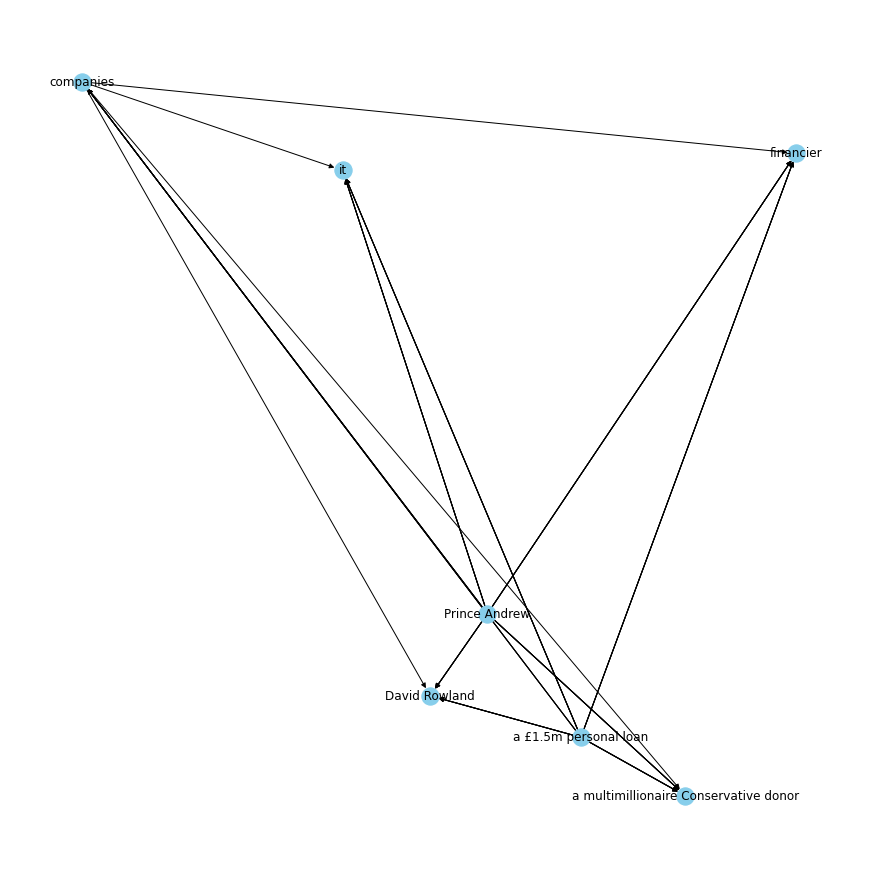

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.random_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

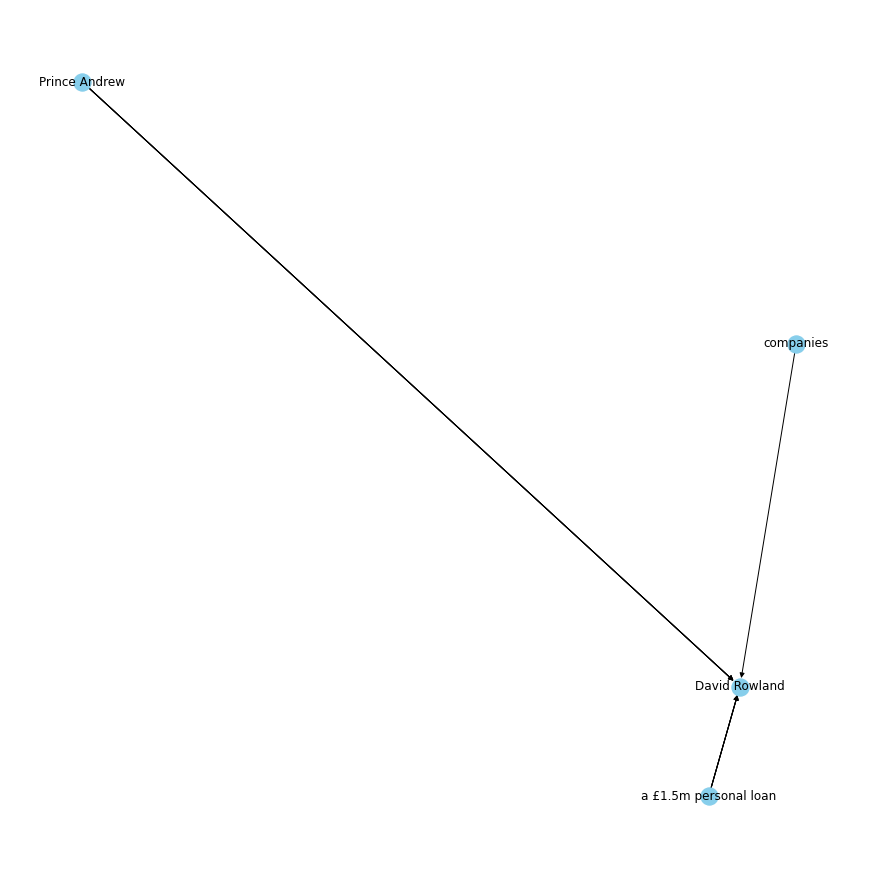

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.from_pandas_edgelist(bank_client_df_target, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.random_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
sentence

'Prince Andrew took out a £1.5m personal loan that was subsequently paid off by companies connected to David Rowland, a multimillionaire Conservative donor and financier, it has been claimed'